# Times Series Modeling 
----

## Pre-Processing Data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import metrics

In [2]:
covid = pd.read_csv('../data/clean_data/covid_cases_us_clean.csv')
covid['submission_date'] = pd.to_datetime(covid['submission_date'])
covid = covid[['submission_date','state','tot_cases','new_case','tot_death','new_death']]
covid.set_index('submission_date', inplace=True)
covid.sort_index(inplace=True)

In [3]:
covid

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [4]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59640 entries, 2020-01-22 to 2022-10-11
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      59640 non-null  object
 1   tot_cases  59640 non-null  int64 
 2   new_case   59640 non-null  int64 
 3   tot_death  59640 non-null  int64 
 4   new_death  59640 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 2.7+ MB


In [5]:
# Creating a copy of dataset to perform modeling
df = covid.copy()
df

,state,tot_cases,new_case,tot_death,new_death
submission_date,,,,,
2020-01-22,AS,0,0,0,0
2020-01-22,NYC,0,0,0,0
2020-01-22,AL,0,0,0,0
2020-01-22,GU,0,0,0,0
2020-01-22,DC,0,0,0,0
...,...,...,...,...,...
2022-10-11,HI,348570,0,1682,0
2022-10-11,MP,13171,0,40,0
2022-10-11,UT,1040147,0,5028,0


In [6]:
df = df.groupby(by=df.index).sum()
df

,tot_cases,new_case,tot_death,new_death
submission_date,,,,
2020-01-22,4,4,0,0
2020-01-23,6,2,0,0
2020-01-24,7,1,0,0
2020-01-25,7,0,0,0
2020-01-26,8,1,0,0
...,...,...,...,...
2022-10-07,96491443,42558,1057306,314
2022-10-08,96502884,11441,1057365,59
2022-10-09,96516506,13622,1057428,63


## 1. ARIMA Models

We trying to build a Time Series on covid cases since the begining of the pandemic so first we need to check for some assumptions like stationarity, trends and seasonalities on the dataset.

In [7]:
# dropping columns
df.drop(columns=['tot_cases','tot_death','new_death'], inplace=True)
df = df.resample('W').mean()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2020-01-26 to 2022-10-16
Freq: W-SUN
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   new_case  143 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


In [9]:
# Run ADF test on original (non-differenced!) data.
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.321261
p-value           0.013954
dtype: float64

In [10]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [11]:
# Checking train tail
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [12]:
# Checking the test head
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

### 1.1. Building a ARIMA(0,1,0)

In [13]:
# Instantiate best model.
arima_010 = ARIMA(endog = y_train, order = (0, 1, 0))

# Fit ARIMA model.
model_010 = arima_010.fit()

# Generate predictions based on test set.
preds_010 = model_010.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_010 = model_010.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_010))

MSE:  1896377434.2340138


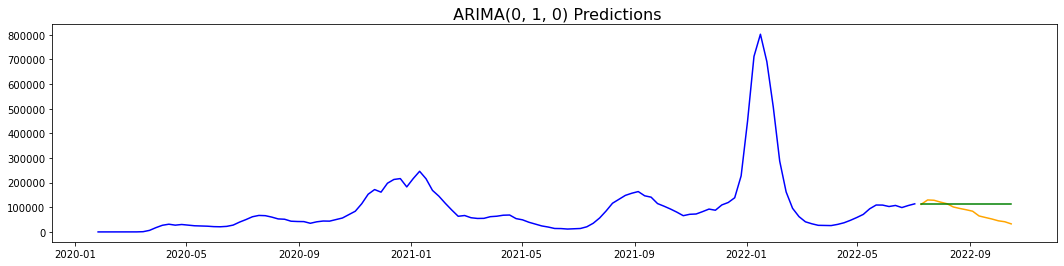

In [14]:
# Plotting the model ARIMA(0,1,0)
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_010, color = 'green')

plt.title(label = ' ARIMA(0, 1, 0) Predictions', fontsize=16);

### 1.2. Building a ARIMA(3,0,1)

In [15]:
# Instantiate best model.
arima_301 = ARIMA(endog = y_train, order = (3, 0, 1))

# Fit ARIMA model.
model_301 = arima_301.fit()

# Generate predictions based on test set.
preds_301 = model_301.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_301 = model_301.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_301))

MSE:  1106435312.930779


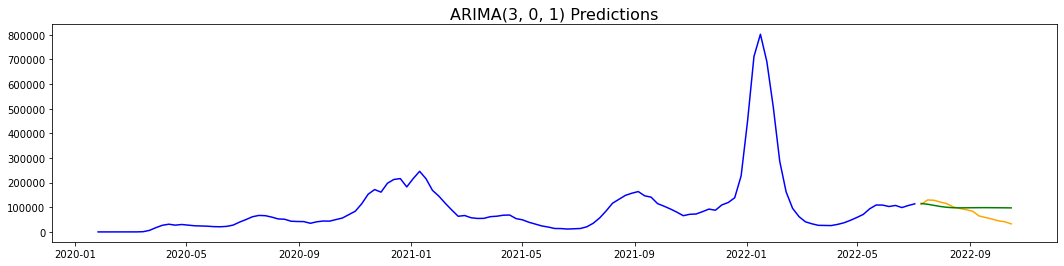

In [16]:
# Plotting  the model ARIMA(3,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_301, color = 'green')

plt.title(label = 'ARIMA(3, 0, 1) Predictions', fontsize=16);

### 1.3. Building a ARIMA(52, 0, 1)

In [17]:
# Instantiate best model.
arima_2201 = ARIMA(endog = y_train, order = (22, 0, 1))

# Fit ARIMA model.
model_2201 = arima_2201.fit()

# Generate predictions based on test set.
preds_2201 = model_2201.predict(start = y_test.index[0], end = y_test.index[-1])

# Generate predictions based on train set.
preds_train_2201 = model_2201.predict(start = y_train.index[0], end = y_train.index[-1])

print('MSE: ',metrics.mean_squared_error(y_test, preds_2201))

/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSE:  1411289005.2213979


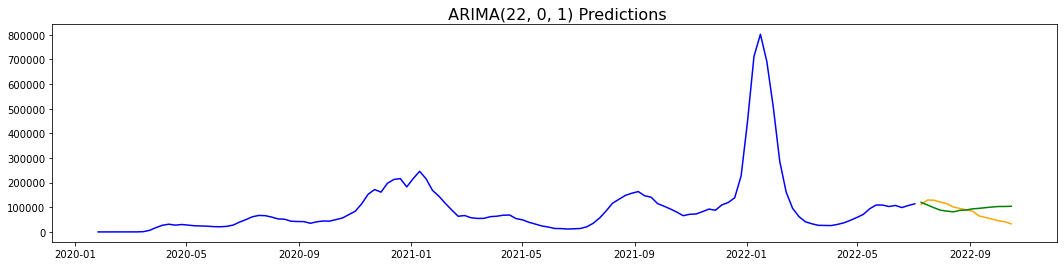

In [18]:
# Plotting  the model ARIMA(22,0,1).
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_2201, color = 'green')

plt.title(label = ' ARIMA(22, 0, 1) Predictions', fontsize=16);

## 2. SARIMA Models

### 2.1. SARIMA(3, 0, 1) x (1, 1, 1, 22)

In [19]:
# Fit a SARIMA(3, 0, 1) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (3, 0, 1),                # (p, d, q)
                  seasonal_order=(1, 1, 1, 22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04523D+01    |proj g|=  1.66716D+00


 This problem is unconstrained.



At iterate    5    f=  9.75048D+00    |proj g|=  2.63298D-02

At iterate   10    f=  9.74065D+00    |proj g|=  3.23227D-03

At iterate   15    f=  9.74050D+00    |proj g|=  4.57135D-04

At iterate   20    f=  9.74050D+00    |proj g|=  4.79322D-04

At iterate   25    f=  9.74042D+00    |proj g|=  6.11918D-03

At iterate   30    f=  9.74030D+00    |proj g|=  2.64407D-04

At iterate   35    f=  9.74028D+00    |proj g|=  1.81832D-03

At iterate   40    f=  9.73924D+00    |proj g|=  2.50992D-02

At iterate   45    f=  9.72743D+00    |proj g|=  1.61997D-01

At iterate   50    f=  9.67105D+00    |proj g|=  5.57173D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/silviaresende/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


794386052.8801112

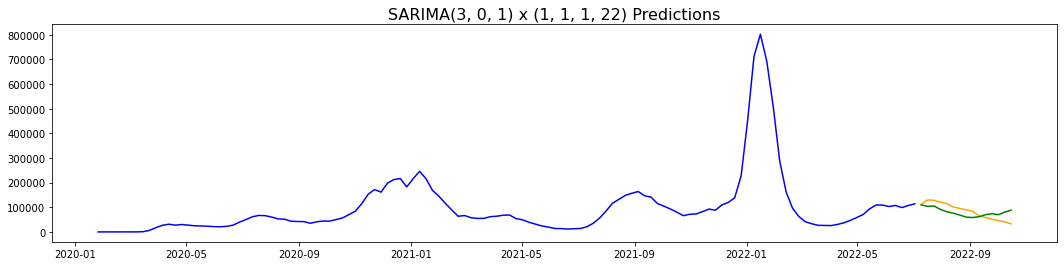

In [20]:
# Plotting SARIMA
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

    #order = (3, 0, 1),                # (p, d, q)
     # seasonal_order=(1,1,1,22))     

plt.title(label = 'SARIMA(3, 0, 1) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

### 2.2. SARIMA(1, 0, 0) x (1, 1, 1, 22) (GridSearch Parameters)

In [21]:
df['diff_1'] = df['new_case'].diff()
df['diff_2'] = df['new_case'].diff().diff()
df.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-01-26,1.600000,NaN,NaN
2020-02-02,0.714286,-0.885714,NaN
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714


In [22]:
df.dropna(inplace=True)
df.head()

,new_case,diff_1,diff_2
submission_date,,,
2020-02-09,1.000000,0.285714,1.171429
2020-02-16,0.571429,-0.428571,-0.714286
2020-02-23,3.428571,2.857143,3.285714
2020-03-01,7.428571,4.000000,1.142857
2020-03-08,103.142857,95.714286,91.714286


In [23]:
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(df['new_case']))

Test Statistic   -3.320787
p-value           0.013974
dtype: float64

In [24]:
# Create train-test split.
y_train, y_test = train_test_split(df['new_case'], test_size = 0.1,shuffle = False)

In [25]:
y_train.tail()

submission_date
2022-06-05    103067.428571
2022-06-12    107407.571429
2022-06-19     98857.285714
2022-06-26    107148.714286
2022-07-03    113983.857143
Freq: W-SUN, Name: new_case, dtype: float64

In [26]:
y_test.head()

submission_date
2022-07-10    111881.000000
2022-07-17    129685.285714
2022-07-24    128469.285714
2022-07-31    120971.000000
2022-08-07    114476.428571
Freq: W-SUN, Name: new_case, dtype: float64

In [27]:
# Fit a SARIMA(1, 0, 0) x (1, 1, 1, 22) model.
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(0,0,0,22))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21685D+01    |proj g|=  2.14268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.274D-06   1.217D+01
  F =   12.168175861504078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [28]:
# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])
# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

328044210.2485147

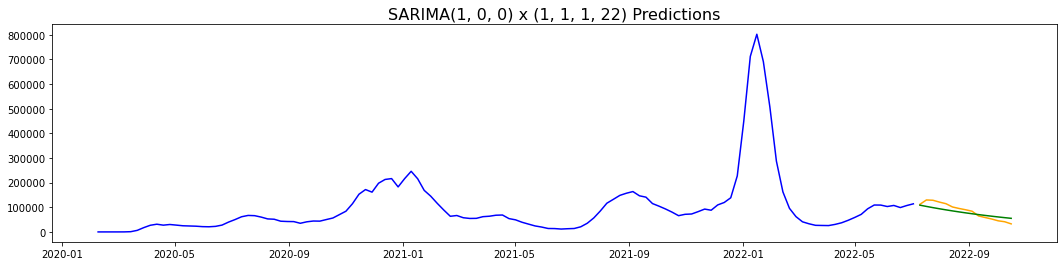

In [29]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'SARIMA(1, 0, 0) x (1, 1, 1, 22) Predictions', fontsize=16)
plt.show();

In [30]:
# Starting MSE and (P, D, Q).
def my_gridsearch():
    mse = 99 * (10 ** 16)
    final_p = 0
    final_d = 0
    final_q = 0
    final_P = 0
    final_D = 0
    final_Q = 0

    for p in range(2):
        for q in range(2):
            for d in range(2):
                for P in range(3):
                    for Q in range(3):
                        for D in range(3):
                            try:
                                sarima = SARIMAX(endog = y_train,
                                                order = (p, d, q),              # (p, d, q)
                                                seasonal_order = (P, D, Q, 22))  # (P, D, Q, S)
                                
                                print(P, D, Q)
                                # Fit SARIMA model.
                                model = sarima.fit()
                                preds_sarima = model.predict(start = y_test.index[0], end = y_test.index[-1])
                                print(f'The MSE for ({p}, {d}, {q})x({P},{D},{Q},22) is: {metrics.mean_squared_error(y_test, preds_sarima)}')#

                                                # Save for final report.
                                if mse > metrics.mean_squared_error(y_test, preds_sarima):
                                    mse = metrics.mean_squared_error(y_test, preds_sarima)
                                    
                                    final_p = p
                                    final_d = d
                                    final_q = q
                                    final_P = P
                                    final_D = D
                                    final_Q = Q
                            except:

                                    pass
        print(f'Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q},22).')
        print(f'This model has an MSE of {mse}.')
    return print('Gridsearach Done!')

In [31]:
#my_gridsearch()

In [32]:
# 27690096390.04778
# 31324938754.810467
# 328044210.2485147

# CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
# The MSE for (1, 1, 1)x(2,2,2,22) is: 31324938754.810467

# Our model that minimizes MSE on the training data is the SARIMA(1, 0, 0)x(0,0,0,22).
# This model has an MSE of 328044210.2485147.

### 2.2. SARIMA(1, 0, 0) x (1, 0, 0, 12) (GridSearch Parameters)

In [33]:
# Fit a SARIMA(1, 0, 0) x (1,0,0,12) model.
sarima = SARIMAX(endog = y_train,
                  order = (1, 0, 0),                # (p, d, q)
                  seasonal_order=(1,0,0,12))       # (P, D, Q, S)

# Fit SARIMA model.
model_sarima = sarima.fit()

# Generate predictions based on test set. # Evaluate predictions MSE.
preds_sarima = model_sarima.predict(start = y_test.index[0], end = y_test.index[-1])

# Evaluate predictions.
metrics.mean_squared_error(y_test, preds_sarima)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22523D+01    |proj g|=  3.74687D-01

At iterate    5    f=  1.21645D+01    |proj g|=  3.32850D-03

At iterate   10    f=  1.21644D+01    |proj g|=  4.30944D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.309D-07   1.216D+01
  F =   12.164388087270808     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


368711933.73655915

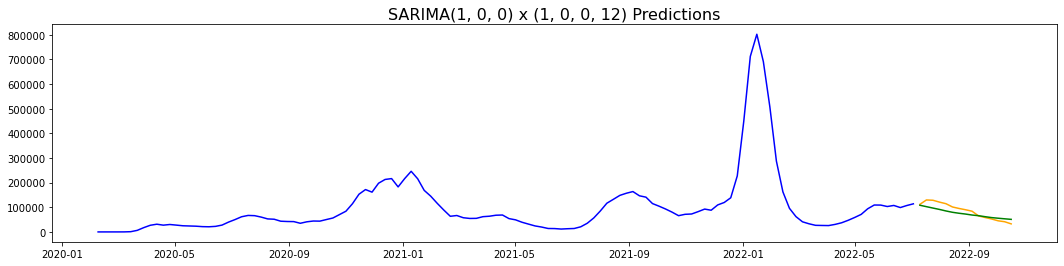

In [34]:
# Plot data.
plt.figure(figsize=(18,4))

# Plot training data.
plt.plot(y_train.index, y_train, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test, color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds_sarima, color = 'green')

plt.title(label = 'SARIMA(1, 0, 0) x (1, 0, 0, 12) Predictions', fontsize=16)
plt.show();